In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from matplotlib import gridspec
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
from cartopy.util import add_cyclic_point
from scipy.stats import linregress
import cmaps
from scipy.stats import f
from scipy.stats import t

d:\anaconda\envs\ES\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
def fu_corr(X, y):
    # 拟合多元线性回归模型
    coefficients = np.linalg.lstsq(X, y, rcond=None)[0]

    # 计算残差
    y_pred = np.dot(X, coefficients)
    residuals = y - y_pred

    # 计算SSE（残差平方和）
    SSE = np.sum(residuals ** 2)

    # 计算总平方和（SST）
    y_mean = np.mean(y)
    SST = np.sum((y - y_mean) ** 2)

    # 计算模型自由度
    n = len(y)
    p = X.shape[1]
    df_model = p
    df_residual = n - p - 1

    # 计算 F 值
    F = (SST - SSE) / (df_model) / (SSE / df_residual)

    # 计算 F 检验的 p 值
    p_value = 1 - f.cdf(F, df_model, df_residual)

    return p_value



def pian_corr(r, df_residual):
    t_value = r * np.sqrt(df_residual) / np.sqrt(1 - r**2)
    p_value = 2 * (1 - t.cdf(x=np.abs(t_value), df=df_residual))
    return p_value

In [3]:
data1 = xr.open_dataset('F:\\hwchen\\output\\data\\6type_3exp_fsds_fsa_fira_lh_h.nc')
data2 = xr.open_dataset('F:\\hwchen\\output\\data\\3type_diff_fsh_fira_et_h2osoi_cldlow.nc')
data3 = xr.open_dataset('F:\\hwchen\\output\\data\\6type_3exp_tsa_tmax_tmin_dtr.nc')
ds = xr.open_dataset('F:\\hwchen\\LUCC_exp\\surfdata.pftdyn_1.9x2.5_rcp4.5_simyr1850-2100_c130422.nc')
land = ds['LANDFRAC_PFT'].values



fsa = data1['fsa'].mean('exp').mean('month').values
et = data2['et'].mean('month').values
tmax = data3['tmax'].mean('exp').mean('month').values
tmin = data3['tmin'].mean('exp').mean('month').values

fsa = fsa[2, ...]
et = et[2, ...]
tmax = tmax[2, ...]
tmin = tmin[2, ...]

d:\anaconda\envs\ES\lib\site-packages\xarray\backends\plugins.py:65: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
rr_tmax_fsa = np.zeros((tmax.shape[1], tmax.shape[2]))
rr_tmax_et = np.zeros((tmax.shape[1], tmax.shape[2]))
rr_tmin_fsa = np.zeros((tmax.shape[1], tmax.shape[2]))
rr_tmin_et = np.zeros((tmax.shape[1], tmax.shape[2]))
rr_fsa_et = np.zeros((tmax.shape[1], tmax.shape[2]))
rr_tmax = np.zeros((tmax.shape[1], tmax.shape[2]))
rr_tmin = np.zeros((tmax.shape[1], tmax.shape[2]))
rr_tmax_fsa_et = np.zeros((tmax.shape[1], tmax.shape[2]))
rr_tmax_et_fsa = np.zeros((tmax.shape[1], tmax.shape[2]))
rr_tmin_fsa_et = np.zeros((tmax.shape[1], tmax.shape[2]))
rr_tmin_et_fsa = np.zeros((tmax.shape[1], tmax.shape[2]))
rr_tmax_fsa = np.zeros((tmax.shape[1], tmax.shape[2]))
pp_tmax = np.zeros((tmax.shape[1], tmax.shape[2]))
pp_tmin = np.zeros((tmax.shape[1], tmax.shape[2]))
pp_tmax_fsa_et = np.zeros((tmax.shape[1], tmax.shape[2]))
pp_tmax_et_fsa = np.zeros((tmax.shape[1], tmax.shape[2]))
pp_tmin_fsa_et = np.zeros((tmax.shape[1], tmax.shape[2]))
pp_tmin_et_fsa =np.zeros((tmax.shape[1], tmax.shape[2]))
const = np.ones(50)

for i in np.arange(tmax.shape[1]):
    for j in np.arange(tmax.shape[2]):
        _, _, rr_tmax_fsa[i, j], _, _ = linregress(tmax[:, i, j], fsa[:, i, j])
        _, _, rr_tmax_et[i, j], _, _ = linregress(tmax[:, i, j], et[:, i, j])
        _, _, rr_tmin_fsa[i, j], _, _ = linregress(tmin[:, i, j], fsa[:, i, j])
        _, _, rr_tmin_et[i, j], _, _ = linregress(tmin[:, i, j], et[:, i, j])
        _, _, rr_fsa_et[i, j], _, _ = linregress(fsa[:, i, j], et[:, i, j])

        arr = np.array([rr_tmax_fsa[i, j], rr_tmax_et[i, j], rr_fsa_et[i, j]])
        has_nan = np.isnan(arr).any()
        if has_nan:
            rr_tmax[i, j] = rr_tmax_fsa_et[i, j] = rr_tmax_et_fsa[i, j] = np.nan
        else:
            rr_tmax[i, j] = np.sqrt((rr_tmax_fsa[i, j]**2 + rr_tmax_et[i, j]**2 - 2*rr_tmax_fsa[i, j]*rr_tmax_et[i, j]*rr_fsa_et[i, j]) / (1 - rr_fsa_et[i, j]**2))
            rr_tmax_fsa_et[i, j] = (rr_tmax_fsa[i, j] - rr_fsa_et[i, j]*rr_tmax_et[i, j]) / np.sqrt((1 - rr_tmax_et[i, j]**2)*(1 - rr_fsa_et[i, j]**2))
            rr_tmax_et_fsa[i, j] = (rr_tmax_et[i, j] - rr_fsa_et[i, j]*rr_tmax_fsa[i, j]) / np.sqrt((1 - rr_tmax_fsa[i, j]**2)*(1 - rr_fsa_et[i, j]**2))
            
            x = np.column_stack((const, fsa[:, i, j], et[:, i, j]))
            pp_tmax[i, j] = fu_corr(x, tmax[:, i, j])
            pp_tmax_fsa_et[i, j] = pian_corr(rr_tmax_fsa_et[i, j], 47)
            pp_tmax_et_fsa[i, j] = pian_corr(rr_tmax_et_fsa[i, j], 47)
        
        arr = np.array([rr_tmin_fsa[i, j], rr_tmin_et[i, j], rr_fsa_et[i, j]])
        has_nan = np.isnan(arr).any()
        if has_nan:
            rr_tmin[i, j] = rr_tmin_fsa_et[i, j] = rr_tmin_et_fsa[i, j] = np.nan
        else:
            rr_tmin[i, j] = np.sqrt((rr_tmin_fsa[i, j]**2 + rr_tmin_et[i, j]**2 - 2*rr_tmin_fsa[i, j]*rr_tmin_et[i, j]*rr_fsa_et[i, j]) / (1 - rr_fsa_et[i, j]**2))
            rr_tmin_fsa_et[i, j] = (rr_tmin_fsa[i, j] - rr_fsa_et[i, j]*rr_tmin_et[i, j]) / np.sqrt((1 - rr_tmin_et[i, j]**2)*(1 - rr_fsa_et[i, j]**2))
            rr_tmin_et_fsa[i, j] = (rr_tmin_et[i, j] - rr_fsa_et[i, j]*rr_tmin_fsa[i, j]) / np.sqrt((1 - rr_tmin_fsa[i, j]**2)*(1 - rr_fsa_et[i, j]**2))
            
            x = np.column_stack((const, fsa[:, i, j], et[:, i, j]))
            pp_tmin[i, j] = fu_corr(x, tmin[:, i, j])
            pp_tmin_fsa_et[i, j] = pian_corr(rr_tmin_fsa_et[i, j], 47)
            pp_tmin_et_fsa[i, j] = pian_corr(rr_tmin_et_fsa[i, j], 47)

plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
mpl.rcParams['font.size']= 16

C:\Users\陈虹玮\AppData\Local\Temp\ipykernel_15928\2486503680.py:252: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(c1, cax=fig.add_axes([0.252, 0.1, 0.525, 0.013]), orientation='horizontal', aspect=10, drawedges=True, extend='both', extendrect=True, extendfrac='auto')


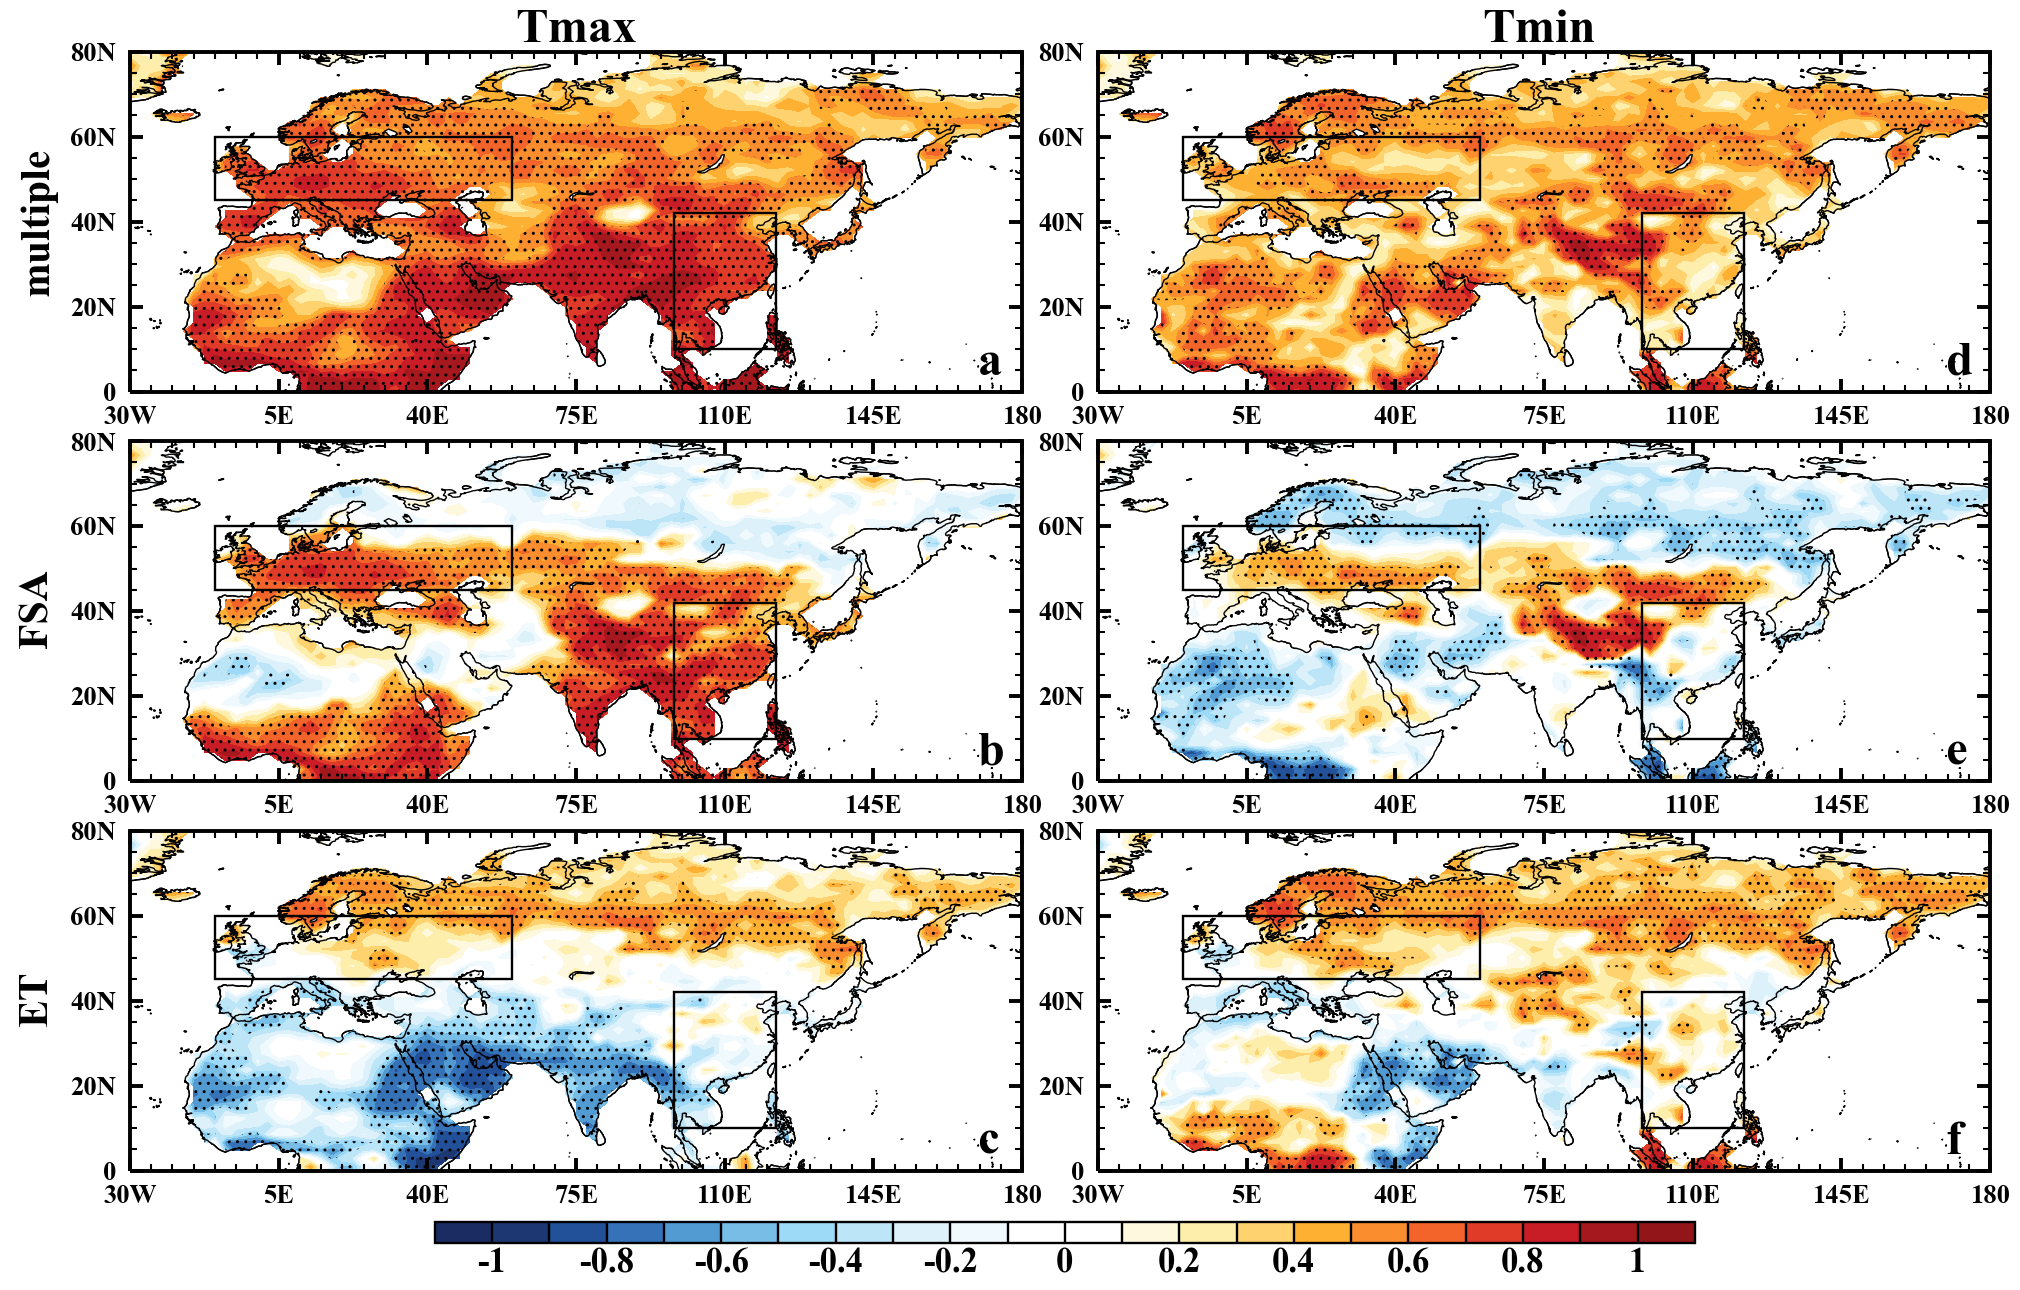

In [21]:
lonmin, lonmax = -30., 180.
latmin, latmax = 0., 80.
lon, lat = data1.lon, data1.lat


rr_tmax_nan = np.where(land > 0.3, rr_tmax, np.nan)
cycle_rr_tmax, cycle_lon = add_cyclic_point(rr_tmax_nan, coord=lon)
cycle_lon, cycle_lat = np.meshgrid(cycle_lon, lat)
pp_tmax_nan = np.where(land > 0.3, pp_tmax, np.nan)
cycle_pp_tmax, cycle_lon = add_cyclic_point(pp_tmax_nan, coord=lon)
cycle_lon, cycle_lat = np.meshgrid(cycle_lon, lat)
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.085, hspace=-0.14)
ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=0))
ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
c1 = ax.contourf(cycle_lon, cycle_lat, cycle_rr_tmax, transform=ccrs.PlateCarree(), cmap=cmaps.BlueWhiteOrangeRed, levels=np.arange(-1, 1.1, 0.1), extend='both')
c1p = ax.contourf(cycle_lon, cycle_lat, cycle_pp_tmax, [0, 0.01], hatches=['..'], colors="none", transform=ccrs.PlateCarree())
ax.add_feature(cfeat.COASTLINE.with_scale('50m'), linewidth=1)
ax.add_feature(cfeat.LAKES.with_scale('110m'),edgecolor='k',facecolor='white',linewidth=1)
ax.add_feature(cfeat.OCEAN.with_scale('50m'), lw=1, facecolor='white', edgecolor='black')
ax.set_xticks([-30, 5, 40, 75, 110, 145, 180], crs=ccrs.PlateCarree())
ax.set_yticks([0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='', zero_direction_label=False)
lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.tick_params(axis="both", which='major', width=2.8, length=9.5, direction='in', right=True, top=True, pad=10)
ax.tick_params(axis="both", which='minor', width=1.5, length=5, direction='in', right=True, top=True)
ax.tick_params(tick2On=True, label2On=False)
ax.spines['geo'].set_linewidth(2.8)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(axis='both', labelsize='large')
lonL_EU, lonR_EU = -10, 60.
latS_EU, latN_EU = 45, 60.
lonL_EA, lonR_EA = 98, 122.
latS_EA, latN_EA = 10, 42.
rect1 = mpl.patches.Rectangle((lonL_EU, latS_EU), lonR_EU-lonL_EU, latN_EU-latS_EU, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.7, zorder = 5,transform=ccrs.PlateCarree())
rect2 = mpl.patches.Rectangle((lonL_EA, latS_EA), lonR_EA-lonL_EA, latN_EA-latS_EA, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.7, zorder = 5,transform=ccrs.PlateCarree())
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.text(0.95, 0.05, f'a', fontsize=35, transform=ax.transAxes)
ax.set_title('Tmax', fontsize=35, weight='bold')
ax.title.set_position((0.5, 1.08))



rr_tmin_nan = np.where(land > 0.3, rr_tmin, np.nan)
cycle_rr_tmin, cycle_lon = add_cyclic_point(rr_tmin_nan, coord=lon)
cycle_lon, cycle_lat = np.meshgrid(cycle_lon, lat)
pp_tmin_nan = np.where(land > 0.3, pp_tmin, np.nan)
cycle_pp_tmin, cycle_lon = add_cyclic_point(pp_tmin_nan, coord=lon)
cycle_lon, cycle_lat = np.meshgrid(cycle_lon, lat)
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=0))
ax2.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
c1 = ax2.contourf(cycle_lon, cycle_lat, cycle_rr_tmin, transform=ccrs.PlateCarree(), cmap=cmaps.BlueWhiteOrangeRed, levels=np.arange(-1, 1.1, 0.1), extend='both')
c1p = ax2.contourf(cycle_lon, cycle_lat, cycle_pp_tmin, [0, 0.01], hatches=['..'], colors="none", transform=ccrs.PlateCarree())
ax2.add_feature(cfeat.COASTLINE.with_scale('50m'), linewidth=1)
ax2.add_feature(cfeat.LAKES.with_scale('110m'),edgecolor='k',facecolor='white',linewidth=1)
ax2.add_feature(cfeat.OCEAN.with_scale('50m'), lw=1, facecolor='white', edgecolor='black')
ax2.set_xticks([-30, 5, 40, 75, 110, 145, 180], crs=ccrs.PlateCarree())
ax2.set_yticks([0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='', zero_direction_label=False)
lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='')
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.tick_params(axis="both", which='major', width=2.8, length=9.5, direction='in', right=True, top=True, pad=10)
ax2.tick_params(axis="both", which='minor', width=1.5, length=5, direction='in', right=True, top=True)
ax2.tick_params(tick2On=True, label2On=False)
ax2.spines['geo'].set_linewidth(2.8)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.tick_params(axis='both', labelsize='large')
lonL_EU, lonR_EU = -10, 60.
latS_EU, latN_EU = 45, 60.
lonL_EA, lonR_EA = 98, 122.
latS_EA, latN_EA = 10, 42.
rect1 = mpl.patches.Rectangle((lonL_EU, latS_EU), lonR_EU-lonL_EU, latN_EU-latS_EU, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.7, zorder = 5,transform=ccrs.PlateCarree())
rect2 = mpl.patches.Rectangle((lonL_EA, latS_EA), lonR_EA-lonL_EA, latN_EA-latS_EA, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.7, zorder = 5,transform=ccrs.PlateCarree())
ax2.add_patch(rect1)
ax2.add_patch(rect2)
plt.text(0.95, 0.05, f'd', fontsize=35, transform=ax2.transAxes)
ax2.set_title('Tmin', fontsize=35, weight='bold')
ax2.title.set_position((0.495, 1.08))



rr_tmax_fsa_et_nan = np.where(land > 0.3, rr_tmax_fsa_et, np.nan)
cycle_rr_tmax_fsa_et, cycle_lon = add_cyclic_point(rr_tmax_fsa_et_nan, coord=lon)
cycle_lon, cycle_lat = np.meshgrid(cycle_lon, lat)
pp_tmax_fsa_et_nan = np.where(land > 0.3, pp_tmax_fsa_et, np.nan)
cycle_pp_tmax_fsa_et, cycle_lon = add_cyclic_point(pp_tmax_fsa_et_nan, coord=lon)
cycle_lon, cycle_lat = np.meshgrid(cycle_lon, lat)
ax3 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=0))
ax3.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
c1 = ax3.contourf(cycle_lon, cycle_lat, cycle_rr_tmax_fsa_et, transform=ccrs.PlateCarree(), cmap=cmaps.BlueWhiteOrangeRed, levels=np.arange(-1, 1.1, 0.1), extend='both')
c1p = ax3.contourf(cycle_lon, cycle_lat, cycle_pp_tmax_fsa_et, [0, 0.01], hatches=['..'], colors="none", transform=ccrs.PlateCarree())
ax3.add_feature(cfeat.COASTLINE.with_scale('50m'), linewidth=1)
ax3.add_feature(cfeat.LAKES.with_scale('110m'),edgecolor='k',facecolor='white',linewidth=1)
ax3.add_feature(cfeat.OCEAN.with_scale('50m'), lw=1, facecolor='white', edgecolor='black')
ax3.set_xticks([-30, 5, 40, 75, 110, 145, 180], crs=ccrs.PlateCarree())
ax3.set_yticks([0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='', zero_direction_label=False)
lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='')
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.tick_params(axis="both", which='major', width=2.8, length=9.5, direction='in', right=True, top=True, pad=10)
ax3.tick_params(axis="both", which='minor', width=1.5, length=5, direction='in', right=True, top=True)
ax3.tick_params(tick2On=True, label2On=False)
ax3.spines['geo'].set_linewidth(2.8)
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(MultipleLocator(5))
ax3.tick_params(axis='both', labelsize='large')
lonL_EU, lonR_EU = -10, 60.
latS_EU, latN_EU = 45, 60.
lonL_EA, lonR_EA = 98, 122.
latS_EA, latN_EA = 10, 42.
rect1 = mpl.patches.Rectangle((lonL_EU, latS_EU), lonR_EU-lonL_EU, latN_EU-latS_EU, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.7, zorder = 5,transform=ccrs.PlateCarree())
rect2 = mpl.patches.Rectangle((lonL_EA, latS_EA), lonR_EA-lonL_EA, latN_EA-latS_EA, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.7, zorder = 5,transform=ccrs.PlateCarree())
ax3.add_patch(rect1)
ax3.add_patch(rect2)
plt.text(0.95, 0.05, f'b', fontsize=35, transform=ax3.transAxes)



rr_tmin_fsa_et_nan = np.where(land > 0.3, rr_tmin_fsa_et, np.nan)
cycle_rr_tmin_fsa_et, cycle_lon = add_cyclic_point(rr_tmin_fsa_et_nan, coord=lon)
cycle_lon, cycle_lat = np.meshgrid(cycle_lon, lat)
pp_tmin_fsa_et_nan = np.where(land > 0.3, pp_tmin_fsa_et, np.nan)
cycle_pp_tmin_fsa_et, cycle_lon = add_cyclic_point(pp_tmin_fsa_et_nan, coord=lon)
cycle_lon, cycle_lat = np.meshgrid(cycle_lon, lat)
ax4 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree(central_longitude=0))
ax4.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
c1 = ax4.contourf(cycle_lon, cycle_lat, cycle_rr_tmin_fsa_et, transform=ccrs.PlateCarree(), cmap=cmaps.BlueWhiteOrangeRed, levels=np.arange(-1, 1.1, 0.1), extend='both')
c1p = ax4.contourf(cycle_lon, cycle_lat, cycle_pp_tmin_fsa_et, [0, 0.01], hatches=['..'], colors="none", transform=ccrs.PlateCarree())
ax4.add_feature(cfeat.COASTLINE.with_scale('50m'), linewidth=1)
ax4.add_feature(cfeat.LAKES.with_scale('110m'),edgecolor='k',facecolor='white',linewidth=1)
ax4.add_feature(cfeat.OCEAN.with_scale('50m'), lw=1, facecolor='white', edgecolor='black')
ax4.set_xticks([-30, 5, 40, 75, 110, 145, 180], crs=ccrs.PlateCarree())
ax4.set_yticks([0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='', zero_direction_label=False)
lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='')
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
ax4.tick_params(axis="both", which='major', width=2.8, length=9.5, direction='in', right=True, top=True, pad=10)
ax4.tick_params(axis="both", which='minor', width=1.5, length=5, direction='in', right=True, top=True)
ax4.tick_params(tick2On=True, label2On=False)
ax4.spines['geo'].set_linewidth(2.8)
ax4.xaxis.set_minor_locator(MultipleLocator(5))
ax4.yaxis.set_minor_locator(MultipleLocator(5))
ax4.tick_params(axis='both', labelsize='large')
lonL_EU, lonR_EU = -10, 60.
latS_EU, latN_EU = 45, 60.
lonL_EA, lonR_EA = 98, 122.
latS_EA, latN_EA = 10, 42.
rect1 = mpl.patches.Rectangle((lonL_EU, latS_EU), lonR_EU-lonL_EU, latN_EU-latS_EU, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.7, zorder = 5,transform=ccrs.PlateCarree())
rect2 = mpl.patches.Rectangle((lonL_EA, latS_EA), lonR_EA-lonL_EA, latN_EA-latS_EA, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.7, zorder = 5,transform=ccrs.PlateCarree())
ax4.add_patch(rect1)
ax4.add_patch(rect2)
plt.text(0.95, 0.05, f'e', fontsize=35, transform=ax4.transAxes)



rr_tmax_et_fsa_nan = np.where(land > 0.3, rr_tmax_et_fsa, np.nan)
cycle_rr_tmax_et_fsa, cycle_lon = add_cyclic_point(rr_tmax_et_fsa_nan, coord=lon)
cycle_lon, cycle_lat = np.meshgrid(cycle_lon, lat)
pp_tmax_et_fsa_nan = np.where(land > 0.3, pp_tmax_et_fsa, np.nan)
cycle_pp_tmax_et_fsa, cycle_lon = add_cyclic_point(pp_tmax_et_fsa_nan, coord=lon)
cycle_lon, cycle_lat = np.meshgrid(cycle_lon, lat)
ax5 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=0))
ax5.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
c1 = ax5.contourf(cycle_lon, cycle_lat, cycle_rr_tmax_et_fsa, transform=ccrs.PlateCarree(), cmap=cmaps.BlueWhiteOrangeRed, levels=np.arange(-1, 1.1, 0.1), extend='both')
c1p = ax5.contourf(cycle_lon, cycle_lat, cycle_pp_tmax_et_fsa, [0, 0.01], hatches=['..'], colors="none", transform=ccrs.PlateCarree())
ax5.add_feature(cfeat.COASTLINE.with_scale('50m'), linewidth=1)
ax5.add_feature(cfeat.LAKES.with_scale('110m'),edgecolor='k',facecolor='white',linewidth=1)
ax5.add_feature(cfeat.OCEAN.with_scale('50m'), lw=1, facecolor='white', edgecolor='black')
ax5.set_xticks([-30, 5, 40, 75, 110, 145, 180], crs=ccrs.PlateCarree())
ax5.set_yticks([0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='', zero_direction_label=False)
lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='')
ax5.xaxis.set_major_formatter(lon_formatter)
ax5.yaxis.set_major_formatter(lat_formatter)
ax5.tick_params(axis="both", which='major', width=2.8, length=9.5, direction='in', right=True, top=True, pad=10)
ax5.tick_params(axis="both", which='minor', width=1.5, length=5, direction='in', right=True, top=True)
ax5.tick_params(tick2On=True, label2On=False)
ax5.spines['geo'].set_linewidth(2.8)
ax5.xaxis.set_minor_locator(MultipleLocator(5))
ax5.yaxis.set_minor_locator(MultipleLocator(5))
ax5.tick_params(axis='both', labelsize='large')
lonL_EU, lonR_EU = -10, 60.
latS_EU, latN_EU = 45, 60.
lonL_EA, lonR_EA = 98, 122.
latS_EA, latN_EA = 10, 42.
rect1 = mpl.patches.Rectangle((lonL_EU, latS_EU), lonR_EU-lonL_EU, latN_EU-latS_EU, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.7, zorder = 5,transform=ccrs.PlateCarree())
rect2 = mpl.patches.Rectangle((lonL_EA, latS_EA), lonR_EA-lonL_EA, latN_EA-latS_EA, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.7, zorder = 5,transform=ccrs.PlateCarree())
ax5.add_patch(rect1)
ax5.add_patch(rect2)
plt.text(0.95, 0.05, f'c', fontsize=35, transform=ax5.transAxes)



rr_tmin_et_fsa_nan = np.where(land > 0.3, rr_tmin_et_fsa, np.nan)
cycle_rr_tmin_et_fsa, cycle_lon = add_cyclic_point(rr_tmin_et_fsa_nan, coord=lon)
cycle_lon, cycle_lat = np.meshgrid(cycle_lon, lat)
pp_tmin_et_fsa_nan = np.where(land > 0.3, pp_tmin_et_fsa, np.nan)
cycle_pp_tmin_et_fsa, cycle_lon = add_cyclic_point(pp_tmin_et_fsa_nan, coord=lon)
cycle_lon, cycle_lat = np.meshgrid(cycle_lon, lat)
ax6 = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree(central_longitude=0))
ax6.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
c1 = ax6.contourf(cycle_lon, cycle_lat, cycle_rr_tmin_et_fsa, transform=ccrs.PlateCarree(), cmap=cmaps.BlueWhiteOrangeRed, levels=np.arange(-1, 1.1, 0.1), extend='both')
c1p = ax6.contourf(cycle_lon, cycle_lat, cycle_pp_tmin_et_fsa, [0, 0.01], hatches=['..'], colors="none", transform=ccrs.PlateCarree())
ax6.add_feature(cfeat.COASTLINE.with_scale('50m'), linewidth=1)
ax6.add_feature(cfeat.LAKES.with_scale('110m'),edgecolor='k',facecolor='white',linewidth=1)
ax6.add_feature(cfeat.OCEAN.with_scale('50m'), lw=1, facecolor='white', edgecolor='black')
ax6.set_xticks([-30, 5, 40, 75, 110, 145, 180], crs=ccrs.PlateCarree())
ax6.set_yticks([0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='', zero_direction_label=False)
lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='')
ax6.xaxis.set_major_formatter(lon_formatter)
ax6.yaxis.set_major_formatter(lat_formatter)
ax6.tick_params(axis="both", which='major', width=2.8, length=9.5, direction='in', right=True, top=True, pad=10)
ax6.tick_params(axis="both", which='minor', width=1.5, length=5, direction='in', right=True, top=True)
ax6.tick_params(tick2On=True, label2On=False)
ax6.spines['geo'].set_linewidth(2.8)
ax6.xaxis.set_minor_locator(MultipleLocator(5))
ax6.yaxis.set_minor_locator(MultipleLocator(5))
ax6.tick_params(axis='both', labelsize='large')
lonL_EU, lonR_EU = -10, 60.
latS_EU, latN_EU = 45, 60.
lonL_EA, lonR_EA = 98, 122.
latS_EA, latN_EA = 10, 42.
rect1 = mpl.patches.Rectangle((lonL_EU, latS_EU), lonR_EU-lonL_EU, latN_EU-latS_EU, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.7, zorder = 5,transform=ccrs.PlateCarree())
rect2 = mpl.patches.Rectangle((lonL_EA, latS_EA), lonR_EA-lonL_EA, latN_EA-latS_EA, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.7, zorder = 5,transform=ccrs.PlateCarree())
ax6.add_patch(rect1)
ax6.add_patch(rect2)
plt.text(0.95, 0.05, f'f', fontsize=35, transform=ax6.transAxes)



ax7 = fig.add_axes([0.075, 0.60, 0.01, 0.213])
ax7.axis('off')
ax7.text(0.4, 0.46, 'multiple', fontsize=30, weight='bold', rotation=90)
ax8 = fig.add_axes([0.075, 0.38, 0.01, 0.213])
ax8.axis('off')
ax8.text(0.4, 0.46, 'FSA', fontsize=30, weight='bold', rotation=90)
ax9 = fig.add_axes([0.075, 0.145, 0.01, 0.213])
ax9.axis('off')
ax9.text(0.4, 0.45, 'ET', fontsize=30, weight='bold', rotation=90)


cbar = fig.colorbar(c1, cax=fig.add_axes([0.252, 0.1, 0.525, 0.013]), orientation='horizontal', aspect=10, drawedges=True, extend='both', extendrect=True, extendfrac='auto')
cbar.ax.tick_params(color='black', width=1.7, direction='out', length=0, labelsize=25)
cbar.dividers.set_linewidth(1.7)
cbar.outline.set_linewidth(1.7)
tick_locs = np.arange(-1, 1.1, 0.1)
tick_labels = ['-1', '', '-0.8', '', '-0.6', '', '-0.4', '', '-0.2', '', '0', '', '0.2', '', '0.4', '', '0.6', '', '0.8', '', '1']
cbar.set_ticks(ticks=tick_locs)
cbar.set_ticklabels(tick_labels)
# plt.savefig(f'F:\\hwchen\\radiation_et_correlation\\picture\\partial_correlation.png', bbox_inches='tight')